<a href="https://colab.research.google.com/github/LuisKolb/MachineLearningWS21/blob/main/ex3-20ng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tqdm

In [2]:
# adapted from https://scikit-learn.org/0.19/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-auto-examples-model-selection-grid-search-text-feature-extraction-py

# Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Mathieu Blondel <mathieu@mblondel.org>
# License: BSD 3 clause

from __future__ import print_function

from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s %(message)s')

# #############################################################################
# Define a pipeline combining a text feature extractor with a simple
# classifier


# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
default_parameters_sgd = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    #'clf__n_iter': (10, 50, 80),
}

def run_model(remove=(), categories=None, clf=SGDClassifier(), parameters=default_parameters_sgd):
    print("Loading 20 newsgroups dataset for categories:")
    print(categories)
    
    data = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
    print("%d documents" % len(data.filenames))
    print("%d categories" % len(data.target_names))
    print()
    
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', clf),
    ])

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(data.data, data.target)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
if __name__ == "__main__":
    categories = [
        'alt.atheism',
        'talk.religion.misc',
    ]
    #categories = None
    
    print('### no preprocessing ###')
    run_model(categories=categories)

    print()
    print('### with headers, footers, quotes (metadata) removed ###')
    run_model(categories=categories, remove=(('headers', 'footers', 'quotes')))
    
    #print()
    #print('### with headers, footers, quotes (metadata) removed ###')
    #run_model(categories=categories,
    #          remove=(('headers', 'footers', 'quotes')),
    #          clf=LogisticRegression(),
    #          parameters={
    #              'vect__max_df': (0.5, 0.75, 1.0),
    #              #'vect__max_features': (None, 5000, 10000, 50000),
    #              'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    #              #'tfidf__use_idf': (True, False),
    #              #'tfidf__norm': ('l1', 'l2'),
    #          })
    

Automatically created module for IPython interactive environment
### no preprocessing ###
Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
done in 60.400s

Best score: 0.950
Best parameters set:
	clf__alpha: 1e-05
	clf__penalty: 'l2'
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)

### with headers, footers, quotes (metadata) removed ###
Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc']
857 documents
2 categories

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1)

In [3]:
import numpy as np

from tqdm import tqdm

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, Reshape
from keras.models import Model

import matplotlib.pyplot as plt
import pandas as pd

import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [4]:
categories = ['sci.crypt', 'sci.electronics'] 
#categories = None



num_cats = 20
if categories:
  num_cats = len(categories)

newsgroups = fetch_20newsgroups(shuffle=True, categories=categories,)

print (newsgroups.target_names)
print (len(newsgroups.data))

df_data = pd.DataFrame(newsgroups.data)
X_train, X_test, y_train, y_test = train_test_split(newsgroups.data, newsgroups.target, test_size=0.5)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4)


X_train_data = tf.convert_to_tensor(X_train)
y_train_data = tf.convert_to_tensor(y_train)

X_val_data = tf.convert_to_tensor(X_val)
y_val_data = tf.convert_to_tensor(y_val)

X_test_data = tf.convert_to_tensor(X_test)
y_test_data = tf.convert_to_tensor(y_test)

#train_data = tf.stack([X_train_data, y_train_data], axis = 0)

['sci.crypt', 'sci.electronics']
1186


## DL prep

In [5]:
# This might be necessary if running locally, depending on your machine's hardware

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [6]:
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)
hub_layer(X_train_data[:3])

2022-02-20 17:31:16,060 INFO Using /tmp/tfhub_modules to cache modules.


<tf.Tensor: shape=(3, 512), dtype=float32, numpy=
array([[-4.5227993e-02,  4.5982655e-02, -5.4304842e-02, ...,
         7.3377371e-02, -2.8729284e-02, -4.4180233e-02],
       [-3.4875162e-02, -1.3729218e-02, -1.6186746e-02, ...,
         4.8609640e-02, -3.1451788e-03, -8.5136943e-02],
       [-2.9586505e-02, -5.6830168e-02,  1.0245519e-05, ...,
         2.8120769e-02, -6.9357090e-02,  3.5066854e-02]], dtype=float32)>

In [7]:
# helper functions

def epoch_plots(history):
  plt.figure(figsize =(5,3))
  plt.plot(history.history['loss'], marker='.', label='train')
  plt.plot(history.history['val_loss'], marker='.', label='validation')
  plt.title('Loss')
  plt.grid(True)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(loc='best')
  plt.show()

  plt.figure(figsize =(5,3))
  plt.plot(history.history['accuracy'], marker='.', label='train')
  plt.plot(history.history['val_accuracy'], marker='.', label='validation')
  plt.title('Accuracy')
  plt.grid(True)
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.legend(loc='best')
  plt.show()

## Basic Models
These are very basic Layer designs to get a baseline reading before further tuning.

### CNN

In [8]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x = X_train_data,
                    y = y_train_data,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_val_data, y_val_data),
                    verbose=1)

results = model.evaluate(x = X_test_data,
                         y = y_test_data,
                         batch_size=128,
                         verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 16)                8208      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,806,049
Trainable params: 256,806,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 14s 1s/step - loss: 0.6785 - accuracy: 0.4761 - val_loss: 0.6470 - val_accuracy: 0.5630
Epoch 2/10
3/3 [==============================] - 3s 1s/step - loss: 0.6148 - accuracy: 0.4761 - val_loss: 0.5804 - val_accuracy: 0.5756
Epoch 3/10
3/3 [===============

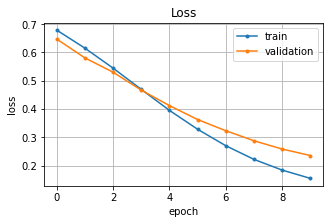

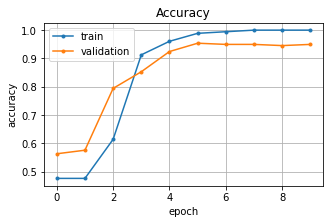

In [9]:
epoch_plots(history)

In [10]:
# depending on your GPU-RAM you might need to clear the model out of memory to avoid OOM-errors
del model

Interesting finding: influence of batch size is very high! We get good accuracy ad default batch size of 32, while batch size of 512 like we used in the movie reviews gives terrible results.

### RNN

In [12]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Reshape((512, 1)))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x = X_train_data,
                    y = y_train_data,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_val_data, y_val_data),
                    verbose=1)

results = model.evaluate(x = X_test_data,
                         y = y_test_data,
                         batch_size=128,
                         verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 reshape_1 (Reshape)         (None, 512, 1)            0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                1152      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 256,798,993
Trainable params: 256,798,993
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3/3 [==============================] - 11s 2s/step - loss: 0.6935 - accuracy: 0.4761 - val_loss: 0.6938 - val_accuracy: 0.5630
Epoch 2/10
3/3 [==================

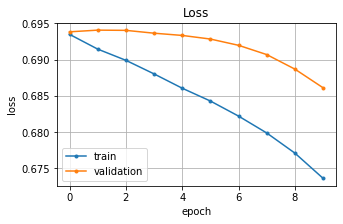

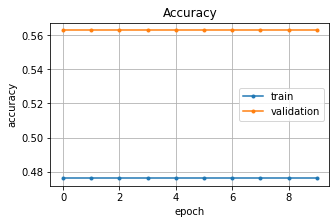

In [13]:
epoch_plots(history)

In [14]:
del model

## More Advanced Models

In [20]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(Reshape(target_shape=( 512 , 1 )))
model.add(Conv1D(512, 1, activation='relu'))
model.add(MaxPooling1D(1))
model.add(Conv1D(512, 1, activation='relu'))
model.add(MaxPooling1D(1))
model.add(Conv1D(512, 1, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dense(1, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x = X_train_data,
                    y = y_train_data,
                    batch_size=128,
                    epochs=10,
                    validation_data=(X_val_data, y_val_data),
                    verbose=1)

results = model.evaluate(x = X_test_data,
                         y = y_test_data,
                         batch_size=128,
                         verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 reshape_5 (Reshape)         (None, 512, 1)            0         
                                                                 
 conv1d_9 (Conv1D)           (None, 512, 512)          1024      
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 512, 512)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 512, 512)          262656    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 512, 512)         0         
 g1D)                                                 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 9s 2s/step - loss: 0.6554 - accuracy: 0.5239 - val_loss: 0.4829 - val_accuracy: 0.4370
Epoch 2/10
3/3 [==============================] - 4s 1s/step - loss: 0.2356 - accuracy: 0.5239 - val_loss: 0.1137 - val_accuracy: 0.4370
Epoch 3/10
3/3 [==============================] - 4s 1s/step - loss: 0.0048 - accuracy: 0.5239 - val_loss: 0.1422 - val_accuracy: 0.4370
Epoch 4/10
3/3 [==============================] - 3s 1s/step - loss: 2.6289e-06 - accuracy: 0.5239 - val_loss: 0.2163 - val_accuracy: 0.4370
Epoch 5/10
3/3 [==============================] - 4s 1s/step - loss: 1.6753e-09 - accuracy: 0.5239 - val_loss: 0.3078 - val_accuracy: 0.4370
Epoch 6/10
3/3 [==============================] - 3s 981ms/step - loss: 1.5981e-12 - accuracy: 0.5239 - val_loss: 0.3990 - val_accuracy: 0.4370
Epoch 7/10
3/3 [==============================] - 3s 1s/step - loss: 4.2213e-15 - accuracy: 0.5239 - val_loss: 0.4829 - val_accuracy: 0.4370
Epoch 8/10
3/3 [=================

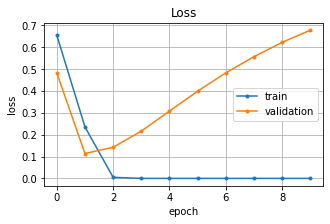

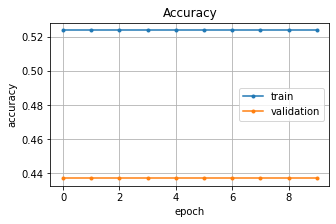

In [21]:
epoch_plots(history)